    Instructions:
    1. Press Run All (or restart kernel and run all cells).
    2. You will be prompted to provide input values.


    Task 5: Let us consider the tag set “Very Relevant (R+)”, “Relevant (R)”, “Irrelevant (I)”, and “Very Irrelevant (I-)”.
    Implement
    – an SVM based relevance feedback system,
    – a probabilistic relevance feedback system – see
        Gerard Salton and Chris Buckley. Improving retrieval performance by relevance feedback. Journal of the
        American Society for Information Science. 41, pp. 288-297, 1990.
    which enable the user to tag some of the results returned by 4b as and then return a new set of ranked results, relying on
    the feedback system selected by the user, either by revising the query or by re-ordering the existing results.

In [6]:
IMAGE_INPUT = input(
"""
Provide one of the following:
1. An Image ID in the Caltech101 dataset in range [0, 8676].
2. The name of an image file in /Code/input/ directory (eg: image.jpg).
"""
)

t = int(input("Enter t, the number of similar images t to find using LSH."))

FEEDBACK_SYSTEM = input(
"""
Enter your choice (number) of relevance feedback system:
1. SVM based relevance feedback system.
2. Probabilistic relevance feedback system
"""
)

LSH_INDEX = "LSH_L10_h5_W5_resnet"

Feedback system chosen:  SVM
Files already downloaded and verified
Input image:  8675


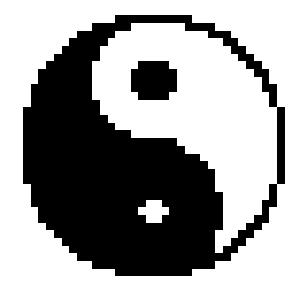

In [7]:
from utils.query_input_processor import get_query_image, get_feedback_system

FEEDBACK_SYSTEM = get_feedback_system(FEEDBACK_SYSTEM)

print("Feedback system chosen: ", "SVM" if FEEDBACK_SYSTEM == 1 else "Probabilistic")

image = get_query_image(IMAGE_INPUT)

print("Input image: ", IMAGE_INPUT)
display(image)

In [8]:
FEATURE_SPACE = LSH_INDEX.split('_')[-1]

if FEATURE_SPACE == 'color':
    from feature_models.color_moments import ColorMomentsExtractor

    vector = ColorMomentsExtractor(image).get_color_vector()

elif FEATURE_SPACE == 'hog':
    from feature_models.hog import HOGExtractor

    vector = HOGExtractor(image).get_hog_vector()

else:
    # ResNet feature model.
    from feature_models.resnet import ResNetExtractor
    resnet = ResNetExtractor(image)

    if FEATURE_SPACE == 'avgpool':
        vector = resnet.get_avgpool_vector()

    elif FEATURE_SPACE == 'layer3':
        vector = resnet.get_layer3_vector()

    elif FEATURE_SPACE == 'fc':
        vector = resnet.get_fc_vector()
    else:
        # resnet feature space.
        vector = resnet.get_output_vector()

In [9]:
# Retrieve LSH in memory structure

from utils.database_utils import compressed_retrieve

lsh = compressed_retrieve(f"{LSH_INDEX}.pt")

from utils.dataset_utils import initialize_dataset
dataset = initialize_dataset()

Files already downloaded and verified


Updating based on new relevance feedback: Image ID: 7324 feedback: R
1.	Image ID: 8632	Relevance: R+	Distance: 18.983827590942383


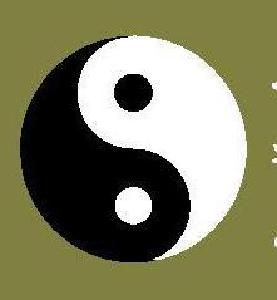

2.	Image ID: 8668	Relevance: R+	Distance: 19.869619369506836


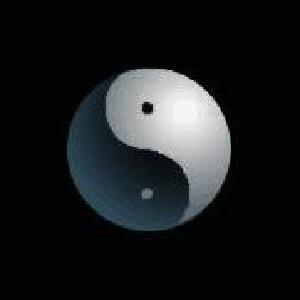

3.	Image ID: 8638	Relevance: Predicted as R+	Distance: 20.955398559570312


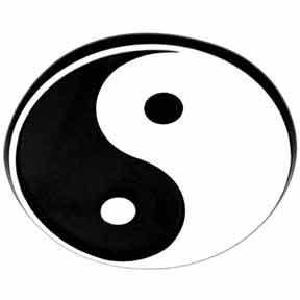

4.	Image ID: 8630	Relevance: Predicted as R+	Distance: 21.011764526367188


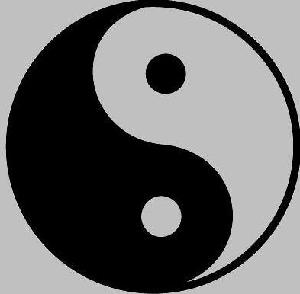

5.	Image ID: 8654	Relevance: Predicted as R+	Distance: 21.66281509399414


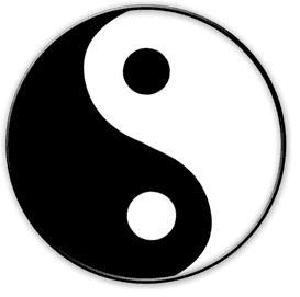

6.	Image ID: 8666	Relevance: Predicted as R+	Distance: 21.989349365234375


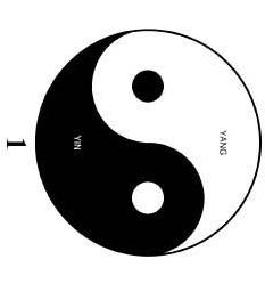

7.	Image ID: 8618	Relevance: Predicted as R+	Distance: 22.596450805664062


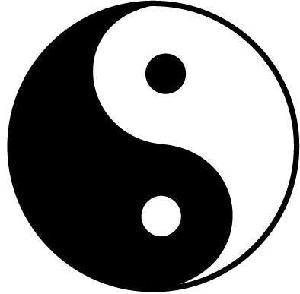

8.	Image ID: 8658	Relevance: Predicted as R+	Distance: 22.82188606262207


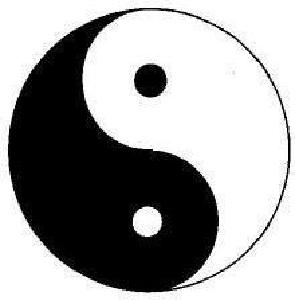

9.	Image ID: 8656	Relevance: Predicted as R+	Distance: 23.504377365112305


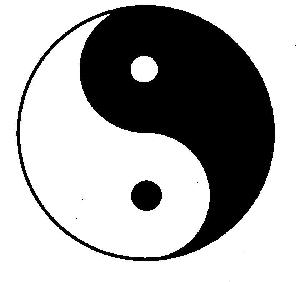

10.	Image ID: 8634	Relevance: Predicted as R+	Distance: 23.628070831298828


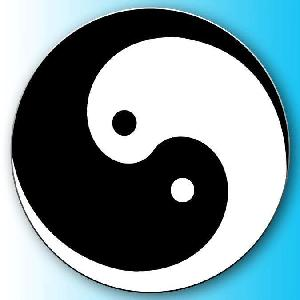

In [10]:
# Relevance feedback on results of LSH.

from utils.query_input_processor import relevance_feedback_input

from IPython.display import clear_output

from utils.distance_utils import make_candidates_hashable_and_update_images

feedbacks_to_apply = {}

candidates = lsh.query(vector, limit=t*30)[0]
query_vector = vector

images = {}

candidates = make_candidates_hashable_and_update_images(vector, candidates, images)

outer_svm, rel_svm, irr_svm = None, None, None

from optimizers.svm_optimizer import generate_svm, get_new_candidates_by_svm
from rerankers.probabilistic_reranker import ProbabilisticReranker
new_candidates = []
first_run = True
prr = ProbabilisticReranker(FEATURE_SPACE)
prr_candidate_tracker = {}
prr_feedbacks = []
while True:
    if FEEDBACK_SYSTEM == 1:
        new_candidates = get_new_candidates_by_svm(candidates, outer_svm, rel_svm, irr_svm, feedbacks_to_apply)
    elif first_run == True:
        first_run = False
        new_candidates = []
        for candidate in candidates:
            _, candidate_image_id, distance = candidate
            new_candidates.append((candidate_image_id, 0, distance, "-"))
        new_candidates.sort(key=lambda x:x[2])
        prr.initialize_candidates(new_candidates)

    for i, vec_tup in enumerate(new_candidates[:t]):
        print(f"{i + 1}.\tImage ID: {vec_tup[0]}\tRelevance: {vec_tup[3]}\tDistance: {vec_tup[2]}")
        display(dataset[vec_tup[0]][0])

    ch = input(
    """
    Provide feedback: Enter the Image ID followed by the feedback (R+, R, I, I-).
    ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤYou can provide multiple feedback, as long as they are separated by commas.
    ㅤㅤㅤㅤㅤㅤㅤㅤㅤEg: 24 R+, 278 I-, 62 R
    ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ
    Note: Results will only change when atleast one R/R+ feedback is provided.
    ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ
    If you do not have any more new relevant results and are stuck, mark the most similar
    as relevant.
    ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ
    If you are done, type Q to stop providing feedback.
    """
    )

    feedbacks = relevance_feedback_input(ch, images.keys())
    if feedbacks is None:
        break
    elif feedbacks == False:
        clear_output()
        print("Invalid input, please try again\n")
        continue
    else:
        clear_output()

    if FEEDBACK_SYSTEM == 1:
        for f in feedbacks:
            img_id, feedback = f

            if feedback in {'R', 'R+'}:
                # Update set of candidates by forming new candidates through querying each relevant vector.
                new_candidates = lsh.query(images[img_id], limit=t*30)[0]

                new_candidates = make_candidates_hashable_and_update_images(vector, new_candidates, images)

                candidates.update(new_candidates)

            feedbacks_to_apply[img_id] = (images[img_id], feedback)
            print("Updating based on new relevance feedback: Image ID:", img_id, "feedback:", feedback)

        outer_svm = generate_svm(feedbacks_to_apply, type_pos={'R', 'R+'}, type_neg={'I', 'I-'})
        rel_svm = generate_svm(feedbacks_to_apply, type_pos={'R+'}, type_neg={'R'})
        irr_svm = generate_svm(feedbacks_to_apply, type_pos={'I'}, type_neg={'I-'})
    else:
        for new_candidate in new_candidates:
            candidate_image_id, _, distance, feedback = new_candidate
            prr_candidate_tracker[candidate_image_id] = (candidate_image_id, feedback, distance)

        # To Do: Persist feedback across multiple iterations
        # To Do: Assign R to top 10 images and allow to be overwritten (will prevent drifting away from goal)
        # for feedback in feedbacks:
        #     for index, prr_feedback in enumerate(prr_feedbacks):
        #         if feedback[0] == prr_feedback[0] and feedback[1] != prr_feedback[1]:
        prr_feedbacks += feedbacks



        for f in prr_feedbacks:
            img_id, feedback = f
            print("Updating based on new relevance feedback: Image ID: ", img_id, " feedback:", feedback)
            prr_candidate_tracker[img_id] = (img_id, feedback, distance)

        print("Updated PRR Candidates:", prr_candidate_tracker)

        prr_candidates = [prr_candidate_tracker[img_id] for img_id in prr_candidate_tracker]
        query_vector_new = prr.get_significance(query_vector, prr_candidates, prr_feedbacks)

        new_candidates = prr.sort_results(query_vector_new, prr_candidates)
        # candidates = lsh.query(query_vector_new, limit=t*30)[0]
        # print(new_candidates)

